In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error
from feature_analysis_functions import plot_top_correlation_heatmap, train_linear_regression, train_random_forest, optimize_random_forest

In [2]:
# Load raw dataset

file_path = '../Resources/data/AmesHousing.csv'
df = pd.read_csv(file_path)
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


## We have our dataset loaded, now we'll preprocess the data for use in ML models.
### Columns with too many empty values will be dropped, as well as the "Overall Condition" and "Neighborhood" feature since we'd like to focus on specific house features.
### We'll impute values for columns with some gaps in the data, and encode categorical data. 

In [3]:
# Pre-process dataset

# Preprocessing data

# Drop irrelevant columns
df_cleaned = df.drop(columns=['Order', 'PID', 'Alley', 'Pool QC', 'Fence', 'Misc Feature', 'Neighborhood', 'Overall Qual', 'Overall Cond'])

# Separate numerical and categorical columns
num_cols = df_cleaned.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df_cleaned.select_dtypes(include=['object']).columns

# Impute missing values
num_imputer = SimpleImputer(strategy="median")
df_cleaned[num_cols] = num_imputer.fit_transform(df_cleaned[num_cols])

cat_imputer = SimpleImputer(strategy="most_frequent")
df_cleaned[cat_cols] = cat_imputer.fit_transform(df_cleaned[cat_cols])

# Define ordinal features and mapping
ordinal_features = {
    "Exter Qual": ["Po", "Fa", "TA", "Gd", "Ex"],
    "Exter Cond": ["Po", "Fa", "TA", "Gd", "Ex"],
    "Bsmt Qual": ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
    "Bsmt Cond": ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
    "Heating QC": ["Po", "Fa", "TA", "Gd", "Ex"],
    "Kitchen Qual": ["Po", "Fa", "TA", "Gd", "Ex"],
    "Fireplace Qu": ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
    "Garage Qual": ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
    "Garage Cond": ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
}

for col, categories in ordinal_features.items():
    encoder = OrdinalEncoder(categories=[categories])
    df_cleaned[col] = encoder.fit_transform(df_cleaned[[col]])

# One-hot encode nominal categorical features
nominal_cat_cols = [col for col in cat_cols if col not in ordinal_features]
df_encoded = pd.get_dummies(df_cleaned, columns=nominal_cat_cols, drop_first=True)

# Scale numerical features
scaler = StandardScaler()
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])

# Display the processed dataset, export cleaned dataset to csv
cleaned_file_path = '../Resources/data/CleanedAmesData.csv'
df_encoded.to_csv(cleaned_file_path, index=False)
df_encoded

,MS SubClass,Lot Frontage,Lot Area,Year Built,Year Remod/Add,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,...,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,-0.877005,3.375742,2.744381,-0.375537,-1.163488,0.061046,2.0,2.0,3.0,4.0,...,False,False,False,False,True,False,False,False,True,False
1,-0.877005,0.514952,0.187097,-0.342468,-1.115542,-0.566039,2.0,2.0,3.0,3.0,...,False,False,False,False,True,False,False,False,True,False
2,-0.877005,0.561850,0.522814,-0.441674,-1.259380,0.038650,2.0,2.0,3.0,3.0,...,False,False,False,False,True,False,False,False,True,False
3,-0.877005,1.124628,0.128458,-0.110988,-0.779919,-0.566039,3.0,2.0,3.0,3.0,...,False,False,False,False,True,False,False,False,True,False
4,0.061285,0.233563,0.467348,0.848000,0.658466,-0.566039,2.0,2.0,4.0,3.0,...,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,0.530430,-1.501671,-0.280621,0.418109,-0.012780,-0.566039,2.0,2.0,3.0,3.0,...,False,False,False,False,True,False,False,False,True,False
2926,-0.877005,-0.047827,-0.160296,0.385040,-0.060726,-0.566039,2.0,2.0,4.0,3.0,...,False,False,False,False,True,False,False,False,True,False
2927,0.647716,-0.329216,0.037199,0.682657,0.370789,-0.566039,2.0,2.0,4.0,3.0,...,False,False,False,False,True,False,False,False,True,False
2928,-0.877005,0.374257,-0.017506,0.087423,-0.444296,-0.566039,2.0,2.0,4.0,3.0,...,False,False,False,False,True,False,False,False,True,False


## We want to do some feature analysis to see which home features are the biggest drivers of a higher sale price. 
### We'll start with a correlation heat map. This will give us a visualization of correlations between the top 15 features most closely correlated with sale price:

Top 15 Features Most Correlated with SalePrice:
['Gr Liv Area', 'Exter Qual', 'Bsmt Qual', 'Kitchen Qual', 'Garage Cars', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Year Built', 'Full Bath', 'Year Remod/Add', 'Foundation_PConc', 'Garage Finish_Unf', 'Garage Yr Blt', 'Mas Vnr Area']


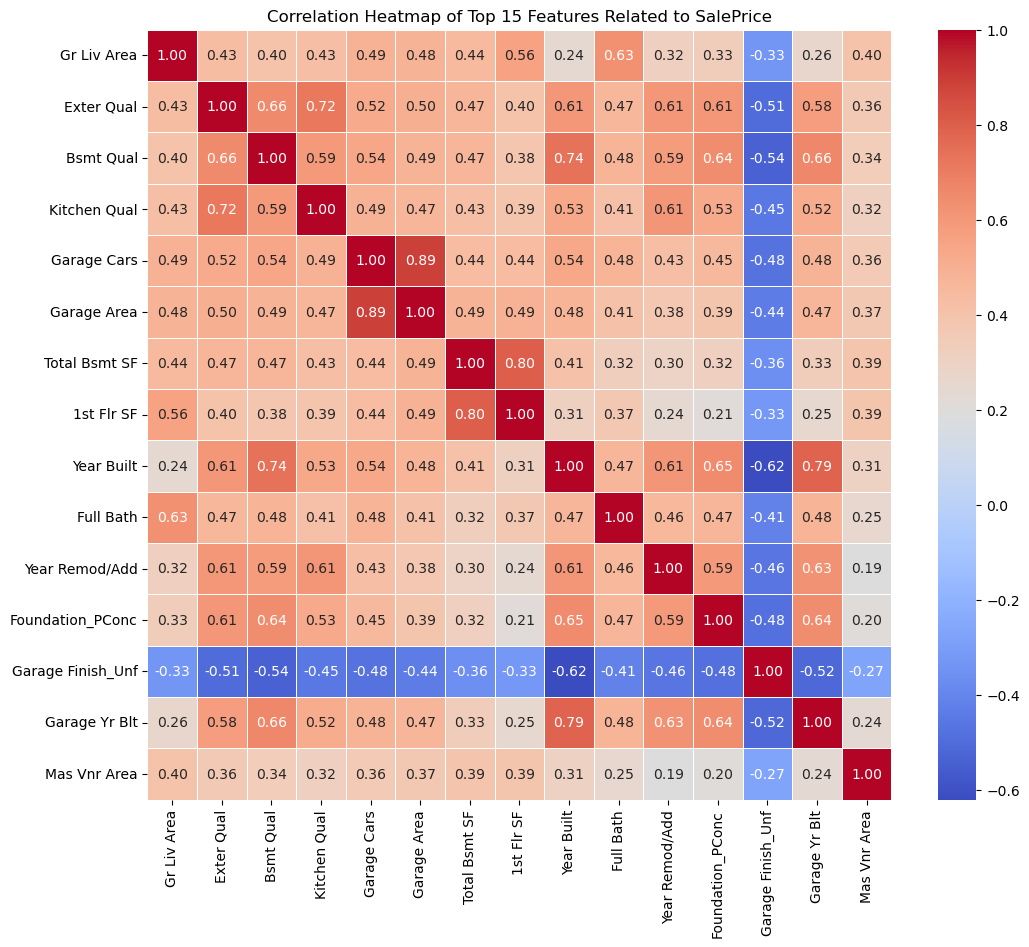

In [4]:
# Import Cleaned Dataset, create correlation heat map for top 15 features

cleaned_df = pd.read_csv(cleaned_file_path)

top_features = plot_top_correlation_heatmap(cleaned_df)

## What the Heat Map tells us: 
### Features like Exterior Condition, Gr Liv Area (Above Ground Living Area), Total Bsmt SF (Total Basement Area), and Garage Area have strong positive correlations with SalePrice. This means that larger homes with bigger basements and garages tend to have higher sale prices.

## Next we'll create some ML models to better wuanitfy the relative impact the features have on sale price.

### We'll use linear regression and random forest models to gain complimentary insights into the dataset.

In [5]:
# Train and evaluate liner regression model and randomn forest model with top 15 features

train_linear_regression(cleaned_df, top_features)

train_random_forest(cleaned_df, top_features)




Linear Regression Performance:
MAE: 0.29230665119343435
MSE: 0.21128814080017663
R2 Score: 0.8318742681392581


Random Forest Performance:
MAE: 0.24082805521706824
MSE: 0.1741599529563126
R2 Score: 0.8614178276134088




## The Random Forest model is a higher performer, so let's so some hyperparameter tuning to try and optimize it:

In [6]:
# Optimize Random forest model 

# Define hyperparameter search space
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Run optimization with Grid Search
optimize_random_forest(df_encoded, top_features, param_grid=param_grid, search_type="grid", output_csv="../Resources/data/rf_tuning_results_grid.csv")

# Run optimization with Random Search
optimize_random_forest(df_encoded, top_features, param_grid=param_grid, search_type="random", output_csv="../Resources/data/rf_tuning_results_random.csv")



Optimized Random Forest Performance (Grid Search):
{'Best Params': {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}, 'MAE': 0.2417560141543832, 'MSE': 0.17181096070741816, 'R2 Score': 0.8632869625278672}

All tuning results saved to: ../Resources/data/rf_tuning_results_grid.csv
Optimized Random Forest Performance (Random Search):
{'Best Params': {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}, 'MAE': 0.2424700087077899, 'MSE': 0.17422735443223195, 'R2 Score': 0.8613641950601358}

All tuning results saved to: ../Resources/data/rf_tuning_results_random.csv


## Hyperparameter Optimization Conclusions: Grid search found a slightly better model but requires more computation. Randomized search is faster and almost the same scores. Both models explain 86% of variance. 

* Grid Search
    * Best parameters:
        * n_estimators=200, max_depth=10, min_samples_split=2, min_samples_leaf=1
    * Performance
        * MAE: 0.2417
        * MSE: 0.1718
        * R2 Score: 0.8633
    * Best Model uses 200 trees and max depth of 10, achieving highest R2 score
* Randomized Search:
    * Best parameters:
        * n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=2
    * Performance:
        * MAE: 0.2424
        * MSE: 0.1742
        * R2 Score: 0.8614
    * Performance very close to Grid Search but uses fewer trees, making it more efficient


### Now let's use our optimized model to plot feature importance

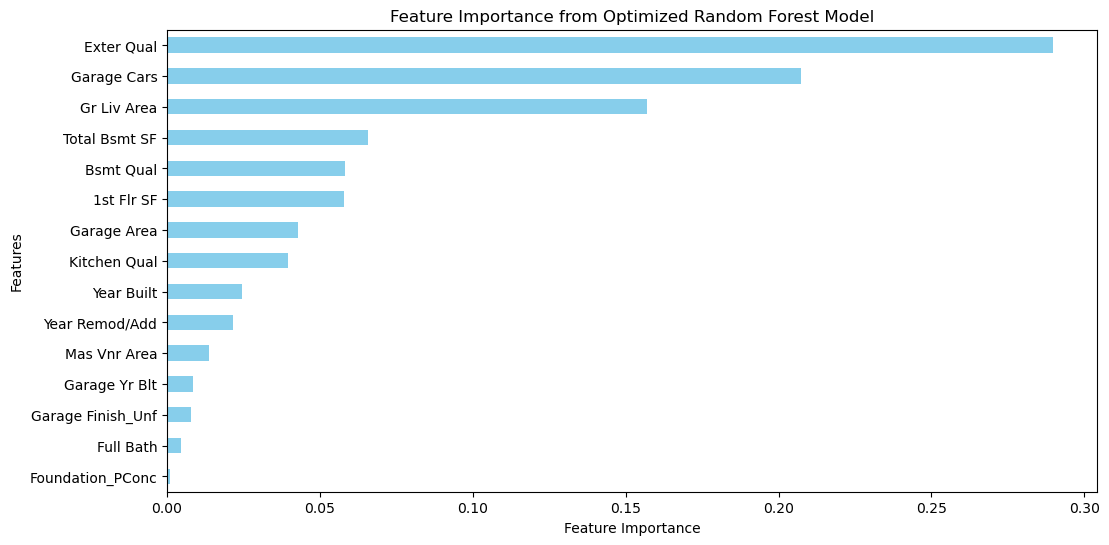

In [7]:
# Define the best parameters manually (from previous optimization results)
best_params = {
    "n_estimators": 200,
    "max_depth": 10,
    "min_samples_split": 2,
    "min_samples_leaf": 1
}

# Select features and target
X = df_encoded[top_features]
y = df_encoded["SalePrice"]

# Train the optimized Random Forest model
rf_model = RandomForestRegressor(**best_params, random_state=42)
rf_model.fit(X, y)

# Create a Pandas Series for feature importance
feature_importances = pd.Series(rf_model.feature_importances_, index=top_features)

# Plot the feature importance
plt.figure(figsize=(12, 6))
feature_importances.sort_values(ascending=True).plot(kind="barh", color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance from Optimized Random Forest Model")
plt.show()

## Conclusions:

### Exterior quality is the most important feature, followed by Garage size and most of the living space size features. Kitchen quality is right behind exterior quality and the overall size of the house. 